==> processing options	
==> downloading dataset	


==> using reduced training data, for fast experiments	
==> loading dataset	


==> preprocessing data	


==> preprocessing data: normalize globally	


==> verify statistics	


training data mean: 6.0247995861573e-09	
training data standard deviation: 0.99999995390695	
test data mean: 0.0051579943078792	
test data standard deviation: 1.0079633546724	
==> visualizing data	


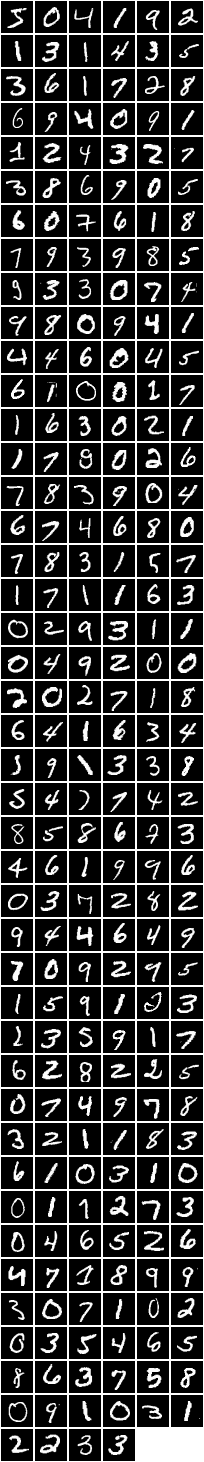

In [1]:
----------------------------------------------------------------------
-- This script demonstrates how to load the (MNIST) Handwritten Digit
-- training data, and pre-process it to facilitate learning.
--
-- It's a good idea to run this script with the interactive mode:
-- $ th -i 1_data.lua
-- this will give you a Torch interpreter at the end, that you
-- can use to analyze/visualize the data you've just loaded.
--
-- Team DeepPurple
----------------------------------------------------------------------

require 'torch'   -- torch
require 'image'   -- for color transforms
require 'nn'      -- provides a normalization operator

----------------------------------------------------------------------
-- parse command line arguments
if not opt then
   print '==> processing options'
   cmd = torch.CmdLine()
   cmd:text()
   cmd:text('MNIST Dataset Preprocessing')
   cmd:text()
   cmd:text('Options:')
   cmd:option('-size', 'small', 'how many samples do we load: small | full')
   cmd:option('-visualize', true, 'visualize input data and weights during training')
   cmd:text()
   opt = cmd:parse(arg or {})
end

----------------------------------------------------------------------
print '==> downloading dataset'

-- Here we download dataset files.

tar = 'http://torch7.s3-website-us-east-1.amazonaws.com/data/mnist.t7.tgz'

data_path = 'mnist.t7'
train_file = paths.concat(data_path, 'train_32x32.t7')
test_file = paths.concat(data_path, 'test_32x32.t7')

if not paths.filep(train_file) or not paths.filep(test_file) then
   os.execute('wget ' .. tar)
   os.execute('tar xvf ' .. paths.basename(tar))
end

----------------------------------------------------------------------
-- training/test size

if opt.size == 'full' then
   print '==> using regular, full training data'
   trsize = 60000
   tesize = 10000
elseif opt.size == 'small' then
   print '==> using reduced training data, for fast experiments'
   trsize = 6000
   tesize = 1000
end

----------------------------------------------------------------------
print '==> loading dataset'

loaded = torch.load(train_file, 'ascii')
trainData = {
   data = loaded.data,
   labels = loaded.labels,
   size = function() return trsize end
}

loaded = torch.load(test_file, 'ascii')
testData = {
   data = loaded.data,
   labels = loaded.labels,
   size = function() return tesize end
}

----------------------------------------------------------------------
print '==> preprocessing data'

-- Preprocessing requires a floating point representation (the original
-- data is stored on bytes). Types can be easily converted in Torch,
-- in general by doing: dst = src:type('torch.TypeTensor'),
-- where Type=='Float','Double','Byte','Int',... Shortcuts are provided
-- for simplicity (float(),double(),cuda(),...):

trainData.data = trainData.data:float()
testData.data = testData.data:float()

-- We now preprocess the data. Preprocessing is crucial
-- when applying pretty much any kind of machine learning algorithm.

-- For natural images, we use several intuitive tricks:
--   + images are mapped into YUV space, to separate luminance information
--     from color information
--   + the luminance channel (Y) is locally normalized, using a contrastive
--     normalization operator: for each neighborhood, defined by a Gaussian
--     kernel, the mean is suppressed, and the standard deviation is normalized
--     to one.
--   + color channels are normalized globally, across the entire dataset;
--     as a result, each color component has 0-mean and 1-norm across the dataset.

-- Convert all images to YUV

-- As we are using MNIST which only has one channel, ignore the above paragraph

-- Normalize each channel, and store mean/std.
-- These values are important, as they are part of
-- the trainable parameters. At test time, test data will be normalized
-- using these values.
print '==> preprocessing data: normalize globally'
mean = trainData.data[{ {},1,{},{} }]:mean()
std = trainData.data[{ {},1,{},{} }]:std()
trainData.data[{ {},1,{},{} }]:add(-mean)
trainData.data[{ {},1,{},{} }]:div(std)

-- Normalize test data, using the training means/stds
testData.data[{ {},1,{},{} }]:add(-mean)
testData.data[{ {},1,{},{} }]:div(std)

----------------------------------------------------------------------
print '==> verify statistics'

-- It's always good practice to verify that data is properly
-- normalized.

trainMean = trainData.data[{ {},1 }]:mean()
trainStd = trainData.data[{ {},1 }]:std()

testMean = testData.data[{ {},1 }]:mean()
testStd = testData.data[{ {},1 }]:std()

print('training data mean: ' .. trainMean)
print('training data standard deviation: ' .. trainStd)

print('test data mean: ' .. testMean)
print('test data standard deviation: ' .. testStd)

----------------------------------------------------------------------
print '==> visualizing data'

-- Visualization is quite easy, using itorch.image().

if opt.visualize then
   if itorch then
      first256Samples = trainData.data[{ {1,256} }]
      itorch.image(first256Samples)
   else
      print("For visualization, run this script in an itorch notebook")
   end
end
